In [53]:
import pandas as pd
import json
from nltk.grammar import CFG, Nonterminal, Production
from nltk.parse import EarleyChartParser
import re
from nltk.tree import Tree
from collections import defaultdict, deque
from benepar import Parser
from nltk.grammar import induce_pcfg, PCFG, ProbabilisticProduction
from nltk.parse.viterbi import ViterbiParser
from tqdm.notebook import tqdm
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')  
# nltk.download('averaged_perceptron_tagger_eng')


In [ ]:
# install the neural parser backend (T5Model etc.)

# pip install benepar | collecting huggingface-hub<1.0,>=0.16.4
import spacy, benepar


# benepar.download("benepar_en3")

# load and init spaCy
nlp = spacy.load("en_core_web_sm") #python -m spacy download en_core_web_sm

# add benepar to the pipeline
nlp.add_pipe("benepar", config={"model": "benepar_en3"})


# Derivative Decomposition of Complex Prepositional Phrases

## Step 1: initialize master lexicon

In [14]:
master_pp_lexicon = {}
# Populate from atomic_p.json
with open('pp_lexicon/atomic_p.json', 'r') as f:
    atomic_p = json.load(f)
    for preposition, features in atomic_p.items():
        master_pp_lexicon[preposition] = features

In [15]:
# Populate from p_lexicon.json
with open('pp_lexicon/p_lexicon.json', 'r') as f:
    p_lexicon = json.load(f)
    for preposition, features in p_lexicon.items():
            master_pp_lexicon[preposition] = features

In [16]:
len(master_pp_lexicon)

79

In [17]:
master_pp_lexicon.keys()

dict_keys(['behind', 'above', 'below', 'beyond', 'in front of', 'inside', 'outside', 'left', 'right', 'against', 'among', 'beside', 'between', 'near', 'next to', 'upon', 'across', 'along', 'around', 'over', 'past', 'through', 'under', 'up', 'down', 'on', 'off', 'in', 'out', 'away', 'top', 'astride', 'corner', 'by', 'edge', 'after', 'but', 'end', 'for', 'base', 'higher', 'high', 'bottom', 'via', 'back', 'at', 'astern', 'following', 'center', 'prior', 'front', 'before', 'opposite', 'from', 'beneath', 'with', 'rear', 'apart', 'next', 'side', 'of', 'far', 'amid', 'skin', 'flank', 'part', 'to', 'board', 'surface', 'a', 'amidst', 'middle', 'rim', 'face', 'close', 'core', 'foot', 'subsequent', 'heart'])

## Step 2: add complex preposition list

In [ ]:
df_pp_wordnet = pd.read_csv('dictionaries/pp_wordnet_dict_wiki_pop_fix.csv', sep=',')
pp_wordnet_wiki = list(df_pp_wordnet['preposition'])
# # drop nan in pp_wordnet_wiki
pp_wordnet_wiki = [x for x in pp_wordnet_wiki if x is not None]


In [19]:
complex_pp_list = []
# check pp_wordnet_wiki against master_pp_lexicon keys
for preposition in pp_wordnet_wiki:
    if preposition not in master_pp_lexicon:
        complex_pp_list.append(preposition)

# remove nan type() float in complex_pp_list
complex_pp_list = [x for x in complex_pp_list if type(x) is str]
complex_pp_list = list(set(complex_pp_list))  # remove duplicates
complex_pp_list.sort()
len(complex_pp_list)

110

In [20]:
# add empty p_lexicon.json entry to complex_pp_list
counter = 0
for key, entry in p_lexicon.items():
    if entry["isAtomicMorph"] == "" and entry["class"] == "" and entry["path_p_morphology"] == "" and entry["measure_allowed"] == "" and entry["spellOutHEAD"] == [""]:
        complex_pp_list.append(key)
        counter += 1

print(counter)

0


In [21]:
with open('pp_lexicon/complex_pp_repop.json', 'w') as f:
    json.dump(complex_pp_list, f, indent=4)
    
len(complex_pp_list)

110

In [22]:
if 'the' in complex_pp_list:
    complex_pp_list.remove('the')
complex_pp_list[-10:]

['until',
 'up to',
 'upside',
 'versus',
 'with a view to',
 'with regard to',
 'with respect to',
 'within',
 'without',
 'worth']

In [23]:
decomposed_result = {} # dictionary to store deomposition results

In [24]:
with open('pp_lexicon/axial_words.json', 'r') as f:
    axial_words = json.load(f)

for ax in axial_words:
    if ax not in master_pp_lexicon.keys():
        print(ax)

underside
cross


### get empty list lexicon in p_lexicon.json

In [25]:
# get empty or "" entries from p_lexicon.json
empty_entries = []
for key, entry in p_lexicon.items():
    if entry["isAtomicMorph"] == "" and entry["class"] == "" and entry["path_p_morphology"] == "" and entry["measure_allowed"] == "" and entry["spellOutHEAD"] == [""]:
        empty_entries.append(key)
    
print(len(empty_entries))

0


In [26]:
# copy p_lexicon.json to dictionary
filled_p_lexicon = {}

for key, entry in p_lexicon.items():
    if entry["isAtomicMorph"] == "" and entry["class"] == "" and entry["path_p_morphology"] == "" and entry["measure_allowed"] == "" and entry["spellOutHEAD"] == [""]:
        continue
    else:
        filled_p_lexicon[key] = entry
        
len(filled_p_lexicon.keys())

# with open('pp_lexicon/p_lexicon.json', 'w') as f:
#     json.dump(filled_p_lexicon, f, indent=4)


49

## Step 3: Decomposition Logic

In [28]:
from abstract_domain_classes import PPFactory

In [ ]:
PATH={'to','from','into','onto','through','across','toward','past'}
PLACE={'in','on','at','under','beside','near','between','among'}
factory = PPFactory('pp_lexicon/atomic_p.json', 'pp_lexicon/p_lexicon.json', 'pp_lexicon/complex_pp_repop.json', PATH, PLACE)
factory.create_classes()

decomposed_result = factory.export_complex_pp()
decomposed_result


{'aboard': {'isAtomicMorph': False,
  'class': ['BOUNDED'],
  'spellOutHEAD': ['*K',
   {'AxPart': '[SURFACE]'},
   '*Deg',
   '*Proj',
   '*p',
   '*Path'],
  'path_p_morphology': ['LOC'],
  'measure_allowed': False},
 'about': {'isAtomicMorph': False,
  'class': ['NOT_SPATIAL'],
  'spellOutHEAD': [],
  'path_p_morphology': ['none'],
  'measure_allowed': False,
  'unlexicalized': ['bout']},
 'absent': {'isAtomicMorph': False,
  'class': ['NOT_SPATIAL'],
  'spellOutHEAD': [],
  'path_p_morphology': ['none'],
  'measure_allowed': False,
  'unlexicalized': ['bsent']},
 'according to': {'isAtomicMorph': False,
  'class': ['EXTENDED'],
  'spellOutHEAD': ['*K', '*AxPart', '*Deg', '*Proj', '*p', {'Path': 'to'}],
  'path_p_morphology': ['GOAL'],
  'measure_allowed': True,
  'unlexicalized': ['ccording']},
 'adjacent': {'isAtomicMorph': False,
  'class': ['NOT_SPATIAL'],
  'spellOutHEAD': [],
  'path_p_morphology': ['none'],
  'measure_allowed': False,
  'unlexicalized': ['djacent']},
 'adjace

In [30]:
unlexicalized_count = 0
for entry in decomposed_result.values():
    unlex = entry.get('unlexicalized')  
    if unlex:                           
        unlexicalized_count += 1

print(f"Number of unlexicalized entries: {unlexicalized_count}")

keys_with_unlex = [
    k
    for k, entry in decomposed_result.items()
    if entry.get("unlexicalized")
]

print(keys_with_unlex)

Number of unlexicalized entries: 65
['about', 'absent', 'according to', 'adjacent', 'adjacent to', 'ahead', 'ahead of', 'as opposed to', 'as per', 'as regards', 'as soon as', 'as well as', 'at least', 'at most', 'at the back of', 'at the behest of', 'at the rear of', 'because of', 'betwixt', 'by means of', 'by virtue of', 'circa', 'concerning', 'despite', 'due to', 'during', 'except', 'except for', 'for the sake of', 'in a higher place', 'in accordance with', 'in addition to', 'in case of', 'in lieu of', 'in place of', 'in point of', 'in spite of', 'including', 'instead of', 'less', 'like', 'minus', 'nearest', 'nigh', 'notwithstanding', 'on account of', 'on behalf of', 'per', 'plus', 'pursuant to', 'rather than', 'regardless of', 'save', 'since', 'such as', 'thanks to', 'to a higher place', 'toward', 'towards', 'until', 'versus', 'with a view to', 'with regard to', 'with respect to', 'worth']


## Merge with base atomic lexicon

In [ ]:
# master_pp_lexicon.update(decomposed_result)
# with open('pp_lexicon/master_pp_lexicon.json', 'w') as f:
#     json.dump(master_pp_lexicon, f, indent=4)

## Step 4: Acquire Spatial Sentences Dataset

### Refclef dataset

In [55]:
df_refer = pd.read_csv('dataset/refer/referitdataset/refclef_unc_flattened.csv')
df_refer

,sent_ids_list,ann_id,ref_id,image_id,split,category_id,tokens,raw,sent_id,sent
0,0,19135_1,0,19135,train,60,sky,sky,0,sky
1,1,19135_2,1,19135,train,235,statue,statue,1,statue
2,2,23412_4,2,23412,train,258,"anywhere,except,the,people",anywhere except the people,2,anywhere except the people
3,3,23412_1,3,23412,train,160,"person,in,front",person in front,3,person in front
4,4,23412_2,4,23412,train,120,"person,all,the,way,in,back",person all the way in back,4,person all the way in back
...,...,...,...,...,...,...,...,...,...,...
130359,"130358,130359",7380_2,99291,7380,train,96,"two,birds,on,left",two birds on left,130359,two birds on left
130360,130360,7380_5,99292,7380,train,182,"palm,tree,to,the,right",palm tree to the right,130360,palm tree to the right
130361,130361,7380_4,99293,7380,train,182,"tree,on,left,side",tree on left side,130361,tree on left side
130362,130362,38047_4,99294,38047,train,34,"bush,bottom,left",bush bottom left,130362,bush bottom left


In [56]:
df_refer['sent']

0                                sky
1                             statue
2         anywhere except the people
3                    person in front
4         person all the way in back
                     ...            
130359             two birds on left
130360        palm tree to the right
130361             tree on left side
130362              bush bottom left
130363                           sky
Name: sent, Length: 130364, dtype: object

#### Inspect most frequent tokens

In [5]:
import nltk
from nltk.corpus import brown

# ensure Brown corpus and the universal tagset are available
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)

# build a set of lower‐cased nouns from the Brown corpus
noun_set = {w.lower() for w, t in brown.tagged_words(tagset='universal') if t == 'NOUN'}

# explode your tokens, drop missing, lowercase them
tokens = df_refer['tokens'].str.split().explode().dropna().str.lower()

# keep only those tokens that are NOT in the Brown corpus noun set
filtered_tokens = tokens[~tokens.isin(noun_set)]

from collections import Counter
most_common_tokens = Counter(filtered_tokens).most_common(20)
print((most_common_tokens))

[('bottom,right,corner', 476), ('bottom,left,corner', 446), ('bottom,right', 413), ('bottom,left', 399), ('the,sky', 386), ('top,left,corner', 347), ('top,right,corner', 338), ('top,right', 291), ('top,left', 271), ('blue,sky', 255), ('bike', 233), ('any,person', 217), ('tree,on,left', 162), ('tree,on,right', 155), ('top,sky', 147), ('tree,left', 138), ('anywhere', 127), ('left,building', 127), ('tree,right', 119), ('sky,top,left', 118)]


In [6]:
most_common_tokens

[('bottom,right,corner', 476),
 ('bottom,left,corner', 446),
 ('bottom,right', 413),
 ('bottom,left', 399),
 ('the,sky', 386),
 ('top,left,corner', 347),
 ('top,right,corner', 338),
 ('top,right', 291),
 ('top,left', 271),
 ('blue,sky', 255),
 ('bike', 233),
 ('any,person', 217),
 ('tree,on,left', 162),
 ('tree,on,right', 155),
 ('top,sky', 147),
 ('tree,left', 138),
 ('anywhere', 127),
 ('left,building', 127),
 ('tree,right', 119),
 ('sky,top,left', 118)]

### Random Sampling for RefClef dataset

In [57]:
# filter df_refer to only sentences longer than 2 tokens
mask = df_refer['sent'].str.split().str.len() > 3
df_refer_filtered = df_refer.loc[mask]
print(f"Sentences longer than 2 tokens: {len(df_refer_filtered)}")

# now sample from the filtered dataframe
# replace n and random_state with your desired values
sampled_df_refer = df_refer_filtered.sample(n=1185, random_state=42)
sampled_df_refer.head()


Sentences longer than 2 tokens: 51338


,sent_ids_list,ann_id,ref_id,image_id,split,category_id,tokens,raw,sent_id,sent
21586,21586,23058_2,15848,23058,train,273,"second,person,from,right",second person from right,21586,second person from right
67160,67160,15940_1,50386,15940,train,60,"any,part,of,sky",any part of sky,67160,any part of sky
66823,66823,3048_10,50123,3048,train,90,"fence,on,the,right",fence on the right,66823,fence on the right
95212,"95212,95213,95214",11547_5,71964,11547,val,114,"bottom,most,glass,front,center",bottom most glass front center,95212,bottom most glass front center
54317,54317,30580_2,40684,30580,train,66,"any,of,the,two,people",Any of the two people,54317,any of the two people


In [58]:
refer_sent = sampled_df_refer['sent'].tolist()
refer_sent[:10]


['second person from right',
 'any part of sky',
 'fence on the right',
 'bottom most glass front center',
 'any of the two people',
 'water to left of object in center screen',
 'fourth flag from left',
 'girl on right with red shirt',
 'the black horse on the right hand side with 2 peeps on it',
 'sky right above the mountain']

### Acquiring REAL_Corpus Dataset

In [59]:
df_real = pd.read_csv('dataset/REAL_Corpus/REAL_Corpus_ReferringExpressionsData_withValidationDetails.csv', delimiter=';')
df_real.head()

,userid,age,gender,photoid,x,y,annotation,status,phrase length,validator_userid,validator_age,validator_gender
0,2,4,male,img23,495,157,Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched windows,correct,123,26,6,male
1,2,4,male,img23,0,0,Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched windows,cantfind,123,41,5,female
2,2,4,male,img23,383,164,Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched windows,correct,123,42,4,female
3,2,4,male,img31,0,0,"Traditional early Victorian terrace on 3 floors + dormer. Third in from the left of the end terrace. Royal Blue Door, Black, spiked iron railings.",ambiguous,147,7,2,female
4,2,4,male,img31,210,421,"Traditional early Victorian terrace on 3 floors + dormer. Third in from the left of the end terrace. Royal Blue Door, Black, spiked iron railings.",correct,147,8,3,female


In [60]:
df_real[df_real['status'] == 'correct'].head()

,userid,age,gender,photoid,x,y,annotation,status,phrase length,validator_userid,validator_age,validator_gender
0,2,4,male,img23,495,157,Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched windows,correct,123,26,6,male
2,2,4,male,img23,383,164,Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched windows,correct,123,42,4,female
4,2,4,male,img31,210,421,"Traditional early Victorian terrace on 3 floors + dormer. Third in from the left of the end terrace. Royal Blue Door, Black, spiked iron railings.",correct,147,8,3,female
5,2,4,male,img31,82,371,"Traditional early Victorian terrace on 3 floors + dormer. Third in from the left of the end terrace. Royal Blue Door, Black, spiked iron railings.",correct,147,9,2,male
6,2,4,male,img21,222,305,"Large, modern glass fronted building, butted up against traditional victorian terrace, slightly set back from road, and with facing bowed frontage.",correct,147,6,2,male


In [61]:
# keep the first row for each unique annotation,
# but carry along every other column
df_real_unique = df_real.drop_duplicates(subset=['annotation'], keep='first') \
                        .reset_index(drop=True)
df_real_unique.iloc[0]

userid                                                                                                                                        2
age                                                                                                                                           4
gender                                                                                                                                     male
photoid                                                                                                                                   img23
x                                                                                                                                           495
y                                                                                                                                           157
annotation          Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched 

In [62]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

df_real_unique['annotation'].head(20)

0                             Pub called 'Deacon Brodie's Tavern. Black and white traditional building with sign hanging outside and 3 big arched windows
1     Traditional early Victorian terrace on 3 floors + dormer. Third in from the left of the end terrace.  Royal Blue Door, Black, spiked iron railings.
2     Large, modern glass fronted building, butted up against traditional victorian terrace, slightly set back from road, and with facing bowed frontage.
3                           Two story traditional stone building, on the left of the street as faced, just before the bed.  Two large white double doors.
4                  Church in the middle of a small square/island - no spire but with large stained glass window in gable end, slightly obscured by trees.
5                                                                      Building with columns behind the one in front, also in similar architecture style.
6                                                                   End cent

In [63]:
df_real_unique.shape

(878, 12)

There's datas which contains multiple sentences. We should split those based on ending punctuation (.?!) occurences.

In [64]:
df_real_unique['annotation'].nunique()

878

In [65]:
df_real_split = df_real_unique.copy()

# split the original annotation string once into sentence lists if contains multiple sentences with ?!.
df_real_split['annotation'] = df_real_split['annotation'].apply(
    lambda s: re.split(r'(?<=[\.\?\!])\s+', s) if isinstance(s, str) else []
)

df_real_split = df_real_split.explode('annotation').reset_index(drop=True)

df_real_split['annotation'] = df_real_split['annotation'].str.strip()
df_real_split = df_real_split[df_real_split['annotation'] != '']
# 4. Join back to the original

df_real_split['annotation'].head(20)


0                                                                                                                     Pub called 'Deacon Brodie's Tavern.
1                                                                 Black and white traditional building with sign hanging outside and 3 big arched windows
2                                                                                               Traditional early Victorian terrace on 3 floors + dormer.
3                                                                                                              Third in from the left of the end terrace.
4                                                                                                           Royal Blue Door, Black, spiked iron railings.
5     Large, modern glass fronted building, butted up against traditional victorian terrace, slightly set back from road, and with facing bowed frontage.
6                                                          Two story traditi

In [66]:
df_real_split['annotation'].nunique()

# to csv
# df_real_split['annotation'].to_csv('dataset/REAL_Corpus/unique_split_annotations.csv', index=False, header=False)

1244

In [67]:
# detect df_real_split['annotation'] which only contain less than 3 tokens
mask = df_real_split['annotation'].str.split().str.len() < 3
df_real_split_filtered = df_real_split[~mask].reset_index(drop=True)
df_real_split_filtered.shape

(1185, 12)

In [68]:
df_real_split_filtered['annotation'].head()

0                                                        Pub called 'Deacon Brodie's Tavern.
1    Black and white traditional building with sign hanging outside and 3 big arched windows
2                                  Traditional early Victorian terrace on 3 floors + dormer.
3                                                 Third in from the left of the end terrace.
4                                              Royal Blue Door, Black, spiked iron railings.
Name: annotation, dtype: object

In [ ]:

with open('dataset/REAL_Corpus/unique_split_annotations_filtered.json', 'r') as f:
    unique_split_annotations_filtered = json.load(f)
    
df_real_split_filtered['annotation'] = unique_split_annotations_filtered

### Real corpus cfg generation

#### CFG + earley 

In [17]:
parser = Parser("benepar_en3")

def create_structural_cfg(sentences):
    trees = []
    for sent in sentences:
        try:
            # parse string → nltk.Tree
            t = parser.parse(sent)
            trees.append(t)
        except Exception as e:
            # optional: log or skip unparseable sentences
            print(f"  skipping (parse failed): {sent!r}  → {e!r}")

    if not trees:
        raise ValueError("No parse trees generated – check your sentences")

    # extract & dedupe productions
    all_prods   = [p for t in trees for p in t.productions()]
    unique_prods = list(dict.fromkeys(all_prods))

    # derive a start symbol that actually appears in LHS
    start_label = trees[0].label()
    start_nt    = Nonterminal(start_label)

    # build a quick lookup for reachability
    prods_by_lhs = defaultdict(list)
    for p in unique_prods:
        prods_by_lhs[p.lhs()].append(p)

    # BFS from the start symbol
    reachable = {start_nt}
    queue     = deque([start_nt])
    while queue:
        lhs = queue.popleft()
        for p in prods_by_lhs[lhs]:
            for sym in p.rhs():
                if isinstance(sym, Nonterminal) and sym not in reachable:
                    reachable.add(sym)
                    queue.append(sym)

    pruned = [p for p in unique_prods if p.lhs() in reachable]
    if not pruned:
        raise ValueError(f"No productions reachable from {start_nt!r}")

    return CFG(start=start_nt, productions=pruned)

/Users/glora/projects/populate-ns-lex/.venv-benepar/lib/python3.9/site-packages/benepar/parse_chart.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [18]:
from tqdm.notebook import tqdm
sentences_clean = [re.sub(r"[^\w\s]", "", s) for s in df_real_split_filtered['annotation'].tolist() if isinstance(s, str)]

# build the CFG and parser
cfg = create_structural_cfg(
    tqdm(
        sentences_clean,
        desc="Building CFG"
    )
)

Building CFG:   0%|          | 0/1185 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/Users/glora/projects/populate-ns-lex/.venv-benepar/lib/python3.9/site-packages/torch/distributions/distribution.py:55: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


#### Derive CFG -> PCFG

In [98]:
from nltk.grammar import induce_pcfg

# assume you’ve already loaded:
#   cfg = CFG.fromstring(cfg_text)
start = cfg.start()
# start = 'TOP'
productions = cfg.productions()

# this will count each production once, then for each nonterminal A
# assign P(rhs | A) = 1 / (# of productions with LHS A)
pcfg = induce_pcfg(start, productions)

# inspect a few rules
for p in pcfg.productions()[:10]:
    print(f"{p}  [{p.prob():.2f}]")


TOP -> NP [0.0833333]  [0.08]
NP -> NP VP [0.00273973]  [0.00]
NP -> NN [0.00273973]  [0.00]
NN -> 'Pub' [0.00176678]  [0.00]
VP -> VBN S [0.00675676]  [0.01]
VBN -> 'called' [0.0126582]  [0.01]
S -> NP [0.02]  [0.02]
NP -> NNP NNP NNP [0.00273973]  [0.00]
NNP -> 'Deacon' [0.00680272]  [0.01]
NNP -> 'Brodies' [0.00680272]  [0.01]


In [99]:
# threshold = 0.01

# 2. filter
# pruned_prods = [p for p in pcfg.productions() if p.prob() >= threshold]

# 3. (optional) re-normalize each LHS so the probabilities sum to 1 again
from collections import defaultdict
grouped = defaultdict(list)
for p in pcfg.productions():
    grouped[p.lhs()].append(p)

repl_prods = []
for lhs, ps in grouped.items():
    total = sum(p.prob() for p in ps)
    for p in ps:
        normalized = p.prob() / total
        # NOTE the `prob=` keyword here
        repl_prods.append(ProbabilisticProduction(lhs, p.rhs(), prob=normalized))


# 4. build the smaller PCFG
small_pcfg = PCFG(pcfg.start(), repl_prods)

print(f"Original rules: {len(pcfg.productions())}")
print(f"Pruned rules:   {len(small_pcfg.productions())}")

Original rules: 2793
Pruned rules:   2793


In [100]:
def build_pcfg_from_pos_tagged(sentences, min_prob=0.001):
    """
    Build a robust PCFG from POS-tagged sentences without external parser.
    
    Args:
        sentences: List of raw sentences
        min_prob: Minimum probability threshold
    
    Returns:
        Robust PCFG based on POS patterns with better coverage
    """
    import nltk
    from nltk import word_tokenize, pos_tag
    
    # Download required NLTK data if not present
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger')
    
    production_counts = Counter()
    word_tag_counts = Counter()
    all_pos_tags = set()
    
    print("Building robust PCFG from POS tags...")
    for sent in tqdm(sentences):
        try:
            # Tokenize and POS tag
            tokens = word_tokenize(sent)
            if not tokens:
                continue
                
            pos_tags = pos_tag(tokens)
            
            # Create word -> POS productions (keep original case for proper nouns)
            for word, pos in pos_tags:
                all_pos_tags.add(pos)
                # Keep original case for proper nouns, lowercase for others
                if pos.startswith('NNP'):
                    word_clean = word
                else:
                    word_clean = word.lower()
                word_tag_counts[(pos, word_clean)] += 1
            
            # Create phrase structure rules
            if len(pos_tags) > 0:
                pos_sequence = [pos for word, pos in pos_tags]
                
                # S -> sequence of POS tags
                s_production = (Nonterminal('S'), tuple(Nonterminal(pos) for pos in pos_sequence))
                production_counts[s_production] += 1
                
                # Create more flexible rules for common patterns
                # Basic sentence patterns
                if len(pos_sequence) >= 2:
                    # S -> NP VP (if we can identify NP and VP regions)
                    np_end = -1
                    vp_start = -1
                    
                    # Find potential NP end and VP start
                    for i, pos in enumerate(pos_sequence):
                        if pos.startswith('N') and np_end == -1:
                            np_end = i
                        elif pos.startswith('V') and vp_start == -1:
                            vp_start = i
                            break
                    
                    if np_end >= 0 and vp_start > np_end:
                        # Add S -> NP VP rule
                        production_counts[(Nonterminal('S'), (Nonterminal('NP'), Nonterminal('VP')))] += 1
                        
                        # Add NP -> sequence from start to np_end
                        np_seq = pos_sequence[:np_end + 1]
                        if len(np_seq) > 0:
                            production_counts[(Nonterminal('NP'), tuple(Nonterminal(pos) for pos in np_seq))] += 1
                        
                        # Add VP -> sequence from vp_start to end
                        vp_seq = pos_sequence[vp_start:]
                        if len(vp_seq) > 0:
                            production_counts[(Nonterminal('VP'), tuple(Nonterminal(pos) for pos in vp_seq))] += 1
                
                # Add some common short patterns
                common_patterns = [
                    # Determiner + Noun patterns
                    (['DT', 'NN'], 'NP'),
                    (['DT', 'NNS'], 'NP'),
                    (['DT', 'NNP'], 'NP'),
                    (['DT', 'JJ', 'NN'], 'NP'),
                    (['DT', 'JJ', 'NNS'], 'NP'),
                    # Verb patterns
                    (['VBZ', 'DT', 'NN'], 'VP'),
                    (['VBD', 'DT', 'NN'], 'VP'),
                    (['VB', 'DT', 'NN'], 'VP'),
                    # Prepositional phrases
                    (['IN', 'DT', 'NN'], 'PP'),
                    (['IN', 'NNP'], 'PP'),
                ]
                
                # Check for these patterns in the sentence
                for pattern_pos, pattern_lhs in common_patterns:
                    for i in range(len(pos_sequence) - len(pattern_pos) + 1):
                        if pos_sequence[i:i+len(pattern_pos)] == pattern_pos:
                            pattern_rhs = tuple(Nonterminal(pos) for pos in pattern_pos)
                            production_counts[(Nonterminal(pattern_lhs), pattern_rhs)] += 1
                        
        except Exception as e:
            print(f"Error processing sentence: {e}")
            continue
    
    # Convert to probabilistic productions
    prob_productions = []
    
    # Word -> POS productions (most important - these must be comprehensive)
    pos_counts = defaultdict(int)
    for (pos, word), count in word_tag_counts.items():
        pos_counts[pos] += count
    
    # Add ALL word productions (no filtering by count for lexical rules)
    for (pos, word), count in word_tag_counts.items():
        prob = count / pos_counts[pos]
        prob_prod = ProbabilisticProduction(Nonterminal(pos), [word], prob=prob)
        prob_productions.append(prob_prod)
    
    # Add unknown word handling - create low-probability productions for common POS tags
    common_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 
                       'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'DT', 'IN', 'CC', 'TO', 'PRP', 'MD']
    
    unknown_prob = 0.0001  # Very low probability for unknown words
    for pos in common_pos_tags:
        if pos in all_pos_tags:  # Only add if we've seen this POS tag
            # Add a generic unknown word production
            prob_prod = ProbabilisticProduction(Nonterminal(pos), ['<UNK>'], prob=unknown_prob)
            prob_productions.append(prob_prod)
    
    # Phrase structure productions
    lhs_counts = defaultdict(int)
    for (lhs, rhs), count in production_counts.items():
        lhs_counts[lhs] += count
    
    for (lhs, rhs), count in production_counts.items():
        prob = count / lhs_counts[lhs]
        if prob >= min_prob:
            prob_prod = ProbabilisticProduction(lhs, list(rhs), prob=prob)
            prob_productions.append(prob_prod)
    
    # Add some basic fallback rules if we don't have enough structure
    if len([p for p in prob_productions if not all(isinstance(sym, str) for sym in p.rhs())]) < 10:
        print("Adding fallback structural rules...")
        # Add very basic fallback rules
        fallback_rules = [
            (Nonterminal('S'), [Nonterminal('NP')], 0.1),
            (Nonterminal('S'), [Nonterminal('VP')], 0.1),
            (Nonterminal('NP'), [Nonterminal('NN')], 0.3),
            (Nonterminal('NP'), [Nonterminal('NNP')], 0.3),
            (Nonterminal('VP'), [Nonterminal('VB')], 0.3),
            (Nonterminal('VP'), [Nonterminal('VBZ')], 0.3),
        ]
        
        for lhs, rhs, prob in fallback_rules:
            prob_prod = ProbabilisticProduction(lhs, rhs, prob=prob)
            prob_productions.append(prob_prod)
    
    print(f"Robust PCFG: {len(prob_productions)} productions")
    print(f"Lexical productions: {len([p for p in prob_productions if all(isinstance(sym, str) for sym in p.rhs())])}")
    print(f"Structural productions: {len([p for p in prob_productions if not all(isinstance(sym, str) for sym in p.rhs())])}")
    
    return PCFG(Nonterminal('S'), prob_productions)

# Enhanced parsing function with unknown word handling
def parse_with_unknown_word_handling(parser, tokens, pcfg):
    """
    Parse tokens with unknown word handling by replacing unknown words with <UNK>
    """
    # Get all words in the grammar
    grammar_words = set()
    for prod in pcfg.productions():
        if all(isinstance(sym, str) for sym in prod.rhs()):
            grammar_words.update(prod.rhs())
    
    # Replace unknown words with <UNK>
    processed_tokens = []
    for token in tokens:
        if token.lower() in grammar_words or token in grammar_words:
            processed_tokens.append(token.lower() if not token[0].isupper() else token)
        else:
            processed_tokens.append('<UNK>')
    
    return list(parser.parse(processed_tokens))

In [101]:
from itertools import islice
from nltk.parse.pchart import InsideChartParser
from tqdm import tqdm

In [54]:
# # 1. build the beam parser once (tune beam_size as you like)
# beam_parser = InsideChartParser(pcfg, beam_size=50)

# with open('dataset/REAL_Corpus/real_corpus_no_symbol.pcfg', 'w', encoding='utf-8') as fout:
#     for sent in tqdm(sentences_clean, desc="Beam parsing"):
#         tokens = sent.split()
#         # parse(tokens) yields all parses that survived the beam, in prob order
#         # here we grab just the 1 best; to get top K, change `1` to K
#         best_trees = list(islice(beam_parser.parse(tokens), 1))
#         if best_trees:
#             # write the single best bracketed tree
#             fout.write(best_trees[0].pformat() + "\n")


In [56]:
import nltk
from nltk.grammar import PCFG, ProbabilisticProduction, Nonterminal
from nltk.parse import ViterbiParser, InsideChartParser
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import re


In [102]:
from tqdm.notebook import tqdm
# clean your sentences
sentences_clean = [
    re.sub(r"[^\w\s]", "", s)
    for s in df_real_split_filtered['annotation']
    if isinstance(s, str)
]

# build your robust PCFG
pcfg = build_pcfg_from_pos_tagged(
    sentences_clean[:500],
    min_prob=0.001
)

viterbi = ViterbiParser(pcfg)

# now parse with unknown word handling
for sent in tqdm(sentences_clean[500:550], desc="Viterbi parsing"):
    tokens = sent.split()
    
    # Use the enhanced parsing function
    trees = parse_with_unknown_word_handling(viterbi, tokens, pcfg)
    
    if trees:
        print(f"\n{sent!r} →", trees[0])
    else:
        print(f"\n{sent!r} → No parse found")

Building robust PCFG from POS tags...


  0%|          | 0/500 [00:00<?, ?it/s]

Robust PCFG: 1888 productions
Lexical productions: 1234
Structural productions: 654


ValueError: Productions for NP do not sum to 1

In [ ]:
# with open('dataset/REAL_Corpus/real_corpus_no_symbol.cfg', 'w', encoding='utf-8') as f:
#     for prod in cfg.productions():
#         f.write(str(prod) + '\n')

In [ ]:
import nltk

parser = EarleyChartParser(cfg)

# parse first 10 sentences with a tqdm progress bar
for sentence in tqdm(sentences_clean[:10],
                     desc="Parsing sentences"):
    tokens = nltk.word_tokenize(sentence)
    print(f"Parsing sentence: {sentence}")
    for tree in parser.parse(tokens):
        print(tree)
        tree.pretty_print()
        print()

Parsing sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing sentence: Pub called Deacon Brodies Tavern


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10749a250>>
Traceback (most recent call last):
  File "/Users/glora/projects/populate-ns-lex/.venv-benepar/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Should I sample refclef with 1245 sentences as well?

In [ ]:
# df_real_split.to_csv

<bound method NDFrame.to_csv of       userid  age  gender photoid    x    y                                                                                                                                    annotation     status  phrase length  validator_userid  validator_age validator_gender
0          2    4    male   img23  495  157                                                                                                            Pub called 'Deacon Brodie's Tavern    correct            123                26              6             male
1          2    4    male   img23  495  157                                                       Black and white traditional building with sign hanging outside and 3 big arched windows    correct            123                26              6             male
2          2    4    male   img31    0    0                                                                                      Traditional early Victorian terrace on 3 floors + dor

In [ ]:
# try:
#     nltk.data.find('taggers/averaged_perceptron_tagger_eng')
#     print("‘averaged_perceptron_tagger_eng’ is installed ")
# except LookupError:
#     print("‘averaged_perceptron_tagger’ is NOT installed  (LookupError raised)")


In [ ]:
try:
    nltk.pos_tag("This is a test".split())
    print("Tagger works!")
except LookupError as e:
    print("LookupError:", e)
    print("So the tagger isn’t installed yet.")


Tagger works!


In [ ]:
# nltk.pos_tag() uses the Penn Treebank Tag Set.
unique_sents = df_real_split['annotation'].unique()

In [ ]:
# # generate cfg rule dump constituent tree as grammar:

# S = Nonterminal('S')
# prod_set = set()

# for sent in unique_sents:
#     tokens = sent.split()

#     tagged = nltk.pos_tag(tokens)  
#     # build the S → POS1 POS2 … production
#     rhs_pos = [Nonterminal(pos) for (_tok, pos) in tagged]
#     prod_set.add(Production(S, rhs_pos))

#     # build each POS → "word" production
#     for word, pos in tagged:
#         prod_set.add(Production(Nonterminal(pos), [word]))


# grammar = CFG(S, list(prod_set))
# # print(grammar)
# parser = EarleyChartParser(grammar)

# # start_sym = trees[0].label()           # usually 'S'

# # prods = list({ p for p in all_prods })  # set-dedupe, original producing 2000 cfg rules
# # grammar = CFG(Nonterminal(start_sym), prods)


# # test on the first sentence
# test_sent = unique_sents_unpunct[1].split()
# for tree in parser.parse(test_sent):
#     print(tree)

(S
  (NNP Black)
  (CC and)
  (JJ white)
  (JJ traditional)
  (NN building)
  (IN with)
  (NN sign)
  (VBG hanging)
  (JJ outside)
  (CC and)
  (CD 3)
  (JJ big)
  (VBD arched)
  (NNS windows))


In [ ]:
# S = Nonterminal('S')
# prods = []

# for sent in unique_sents:
#     tagged = nltk.pos_tag(sent.split())
#     prev_nt = S

#     # for each token except the last, build NT_i → POS_i NT_{i+1}
#     for i, (w, pos) in enumerate(tagged[:-1]):
#         curr_nt = Nonterminal(f"X{i}")
#         prods.append(Production(prev_nt, [Nonterminal(pos), curr_nt]))
#         prods.append(Production(Nonterminal(pos), [w]))
#         prev_nt = curr_nt

#     # final link: X_{n-1} → POS_n
#     last_word, last_pos = tagged[-1]
#     prods.append(Production(prev_nt, [Nonterminal(last_pos)]))
#     prods.append(Production(Nonterminal(last_pos), [last_word]))

# grammar = CFG(S, prods)
# parser = EarleyChartParser(grammar)

# print(grammar)


#### spaCy+benepar PCFG Neural Parser

In [18]:
from nltk import Tree

In [32]:
df_real_split_filtered['annotation'].shape
real_split_annotations = df_real_split_filtered['annotation'].tolist()

print(real_split_annotations[:10])

["Pub called 'Deacon Brodie's Tavern.", 'Black and white traditional building with sign hanging outside and 3 big arched windows', 'Traditional early Victorian terrace on 3 floors + dormer.', 'Third in from the left of the end terrace.', 'Royal Blue Door, Black, spiked iron railings.', 'Large, modern glass fronted building, butted up against traditional victorian terrace, slightly set back from road, and with facing bowed frontage.', 'Two story traditional stone building, on the left of the street as faced, just before the bed.', 'Two large white double doors.', 'Church in the middle of a small square/island - no spire but with large stained glass window in gable end, slightly obscured by trees.', 'Building with columns behind the one in front, also in similar architecture style.']


In [ ]:

nlp = spacy.load("en_core_web_sm")

# benepar.download("benepar_en3")
nlp.add_pipe("benepar", config={"model": "benepar_en3"})


/Users/glora/projects/populate-ns-lex/.venv-benepar/lib/python3.9/site-packages/benepar/parse_chart.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [ ]:
# punct_tags = {",", ":", "``", "''", ".", "(", ")", "--", "``", "+"}

# unique_sents_unpunct = [
#     sent for sent in unique_sents if not any(tag in sent for tag in punct_tags) # reduced 50% rules
# ]

In [33]:
# 2. collect all the parse trees with a progress bar
clean_annotations = [" ".join(s.split()) for s in real_split_annotations]

trees = []
for doc in tqdm(nlp.pipe(clean_annotations), desc="Parsing docs"):
    for sent in doc.sents:
        bracketed = sent._.parse_string
        trees.append(Tree.fromstring(bracketed))


Parsing docs: 0it [00:00, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/Users/glora/projects/populate-ns-lex/.venv-benepar/lib/python3.9/site-packages/torch/distributions/distribution.py:55: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [34]:
# 3. extract productions with a progress bar
all_prods_real_corpus = []
for t in trees:
    all_prods_real_corpus.extend(t.productions())

# 4. build a grammar (dedupe productions)
start_sym = 'S'
prods = list({p for p in all_prods_real_corpus})
grammar = CFG(Nonterminal(start_sym), prods)

all_prods_real_corpus


[NP -> NP VP .,
 NP -> NN,
 NN -> 'Pub',
 VP -> VBN S,
 VBN -> 'called',
 S -> `` NP,
 `` -> "'",
 NP -> NP NNP,
 NP -> NNP NNP POS,
 NNP -> 'Deacon',
 NNP -> 'Brodie',
 POS -> "'s",
 NNP -> 'Tavern',
 . -> '.',
 NP -> NP PP,
 NP -> ADJP JJ NN,
 ADJP -> JJ CC JJ,
 JJ -> 'Black',
 CC -> 'and',
 JJ -> 'white',
 JJ -> 'traditional',
 NN -> 'building',
 PP -> IN NP,
 IN -> 'with',
 NP -> NP CC NP,
 NP -> NP VP,
 NP -> NN,
 NN -> 'sign',
 VP -> VBG ADVP,
 VBG -> 'hanging',
 ADVP -> RB,
 RB -> 'outside',
 CC -> 'and',
 NP -> CD JJ JJ NNS,
 CD -> '3',
 JJ -> 'big',
 JJ -> 'arched',
 NNS -> 'windows',
 NP -> NP PP .,
 NP -> JJ ADJP NN,
 JJ -> 'Traditional',
 ADJP -> JJ JJ,
 JJ -> 'early',
 JJ -> 'Victorian',
 NN -> 'terrace',
 PP -> IN NP,
 IN -> 'on',
 NP -> NP CC NP,
 NP -> CD NNS,
 CD -> '3',
 NNS -> 'floors',
 CC -> '+',
 NP -> JJR,
 JJR -> 'dormer',
 . -> '.',
 FRAG -> ADVP PP .,
 ADVP -> JJ RB,
 JJ -> 'Third',
 RB -> 'in',
 PP -> IN NP,
 IN -> 'from',
 NP -> NP PP,
 NP -> DT NN,
 DT -> '

In [ ]:
# # dump your list of productions to disk
# with open('dataset/REAL_Corpus/real_corpus_prod.cfg', 'w') as fw:
#     for prod in all_prods_real_corpus:
#         fw.write(f"{prod}\n")

with open('dataset/REAL_Corpus/real_corpus_prod.cfg') as fr:
    all_prods_real_corpus = [line.strip() for line in fr if line.strip()]

In [38]:
all_prods_real_corpus = [line.strip() for line in all_prods_real_corpus if line.strip()]
all_prods_real_corpus

['NP -> NP VP .',
 'NP -> NN',
 "NN -> 'Pub'",
 'VP -> VBN S',
 "VBN -> 'called'",
 'S -> `` NP',
 '`` -> "\'"',
 'NP -> NP NNP',
 'NP -> NNP NNP POS',
 "NNP -> 'Deacon'",
 "NNP -> 'Brodie'",
 'POS -> "\'s"',
 "NNP -> 'Tavern'",
 ". -> '.'",
 'NP -> NP PP',
 'NP -> ADJP JJ NN',
 'ADJP -> JJ CC JJ',
 "JJ -> 'Black'",
 "CC -> 'and'",
 "JJ -> 'white'",
 "JJ -> 'traditional'",
 "NN -> 'building'",
 'PP -> IN NP',
 "IN -> 'with'",
 'NP -> NP CC NP',
 'NP -> NP VP',
 'NP -> NN',
 "NN -> 'sign'",
 'VP -> VBG ADVP',
 "VBG -> 'hanging'",
 'ADVP -> RB',
 "RB -> 'outside'",
 "CC -> 'and'",
 'NP -> CD JJ JJ NNS',
 "CD -> '3'",
 "JJ -> 'big'",
 "JJ -> 'arched'",
 "NNS -> 'windows'",
 'NP -> NP PP .',
 'NP -> JJ ADJP NN',
 "JJ -> 'Traditional'",
 'ADJP -> JJ JJ',
 "JJ -> 'early'",
 "JJ -> 'Victorian'",
 "NN -> 'terrace'",
 'PP -> IN NP',
 "IN -> 'on'",
 'NP -> NP CC NP',
 'NP -> CD NNS',
 "CD -> '3'",
 "NNS -> 'floors'",
 "CC -> '+'",
 'NP -> JJR',
 "JJR -> 'dormer'",
 ". -> '.'",
 'FRAG -> ADVP PP 

In [39]:
from nltk import Nonterminal

lexical   = [p for p in prods if all(not isinstance(sym, Nonterminal) for sym in p.rhs())]
nonlexical= [p for p in prods if any(isinstance(sym, Nonterminal)     for sym in p.rhs())]

print(f"lexical rules  = {len(lexical)}")
print(f"nonlexical rules = {len(nonlexical)}")


lexical rules  = 1963
nonlexical rules = 976


cfg shrinking rule by only keeping nonlexical rules:

In [ ]:

from constituent_treelib import ConstituentTree, Structure



from constituent_treelib import ConstituentTree, BracketedTree, Language, Structure

language = Language.English
nlp = ConstituentTree.create_pipeline(language, ConstituentTree.SpacyModelSize.Small)


def make_pos_cfg_and_parse(text):

    doc     = nlp(text)
    tokens  = [tok.text for tok in doc]
    pos_seq = [tok.tag_ for tok in doc]

    # build CTL tree without token leaves -> leaf POS tag
    ctl = ConstituentTree(doc, nlp, Structure.WithoutTokenLeaves)

    
    tree = ctl.tree  # NLTK tree obj
    prods = tree.productions()
    G     = CFG(Nonterminal("S"), prods)


    parser = EarleyChartParser(G)
    try:
        G.check_coverage(pos_seq)
    except ValueError as e:
        raise RuntimeError(f"Missing POS in lexicon: {e}")    
    parse = next(parser.parse(pos_seq), None)
    if parse is None:
        raise RuntimeError("No parse found!")

    i = 0
    for subtree in parse.subtrees():
        # pre-terminals have height()==2, i.e. (TAG leaf)
        if subtree.height() == 2:
            subtree[0] = tokens[i]
            i += 1

    return parse

sentence = "Pub called 'Deacon Brodie's Tavern."
parsed_tree = make_pos_cfg_and_parse(sentence)
print(parsed_tree.pformat(margin=60))


[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /Users/glora/projects/populate-ns-lex/.venv-
[nltk_data]     benepar/share/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


LanguageError: The detected language of the given sentence is not supported. Currently, ConstituentTree only supports: English, German, French, Polish, Hungarian, Swedish, Chinese and Korean.

In [51]:
# Define the language for the sentence as well as for the spaCy and benepar models
language = Language.English
nlp = ConstituentTree.create_pipeline(language, ConstituentTree.SpacyModelSize.Small)

def clean_text_aggressively(text):
    """More aggressive text cleaning to help language detection"""
    # Replace smart quotes and special characters
    cleaned = text.replace(''', "'").replace(''', "'").replace('"', '"').replace('"', '"')
    
    # Replace problematic characters that might confuse language detection
    cleaned = cleaned.replace('+', 'and')  # Replace + with 'and'
    cleaned = re.sub(r'\d+', 'NUM', cleaned)  # Replace numbers with 'NUM'
    
    # Ensure proper sentence structure
    if not cleaned.strip().endswith(('.', '!', '?')):
        cleaned = cleaned.strip() + '.'
    
    # Remove extra spaces
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    return cleaned

def make_text_more_english(text):
    """Make text more obviously English to help language detection"""
    # Add common English words to help detection
    if not any(word in text.lower() for word in ['the', 'a', 'an', 'is', 'was', 'are', 'were']):
        # Prepend with "This is" to make it more clearly English
        return f"This is {text.lower()}"
    return text

def make_pos_cfg_and_parse_v1(text):
    """Version 1: Aggressive text cleaning"""
    print(f"Original text: {text}")
    
    # Clean the text aggressively
    cleaned_text = clean_text_aggressively(text)
    print(f"Cleaned text: {cleaned_text}")
    
    # Tokenize & POS-tag
    doc = nlp(cleaned_text)
    tokens = [tok.text for tok in doc]
    pos_seq = [tok.tag_ for tok in doc]
    
    print(f"Tokens: {tokens}")
    print(f"POS tags: {pos_seq}")
    
    # Build CTL tree without the sentence_language parameter
    ctl = ConstituentTree(doc, nlp, Structure.WithoutTokenLeaves)
    
    # Extract productions and make CFG
    tree = ctl.tree
    prods = tree.productions()
    G = CFG(Nonterminal("S"), prods)
    
    print(f"Grammar productions: {len(prods)}")
    
    # Parse the POS sequence
    parser = EarleyChartParser(G)
    try:
        G.check_coverage(pos_seq)
    except ValueError as e:
        print(f"Grammar coverage issue: {e}")
        terminals = set()
        for prod in prods:
            if prod.is_lexical():
                terminals.add(prod.rhs()[0])
        print(f"Available POS tags in grammar: {sorted(terminals)}")
        print(f"Required POS tags: {pos_seq}")
        raise RuntimeError(f"Missing POS in lexicon: {e}")
    
    parses = list(parser.parse(pos_seq))
    if not parses:
        raise RuntimeError("No parse found!")
    
    print(f"Found {len(parses)} parse(s)")
    parse = parses[0]
    
    # Re-attach original tokens (not cleaned ones)
    original_doc = nlp(text.replace(''', "'").replace(''', "'").replace('"', '"').replace('"', '"'))
    original_tokens = [tok.text for tok in original_doc]
    
    i = 0
    for subtree in parse.subtrees():
        if subtree.height() == 2 and i < len(original_tokens):
            subtree[0] = original_tokens[i]
            i += 1
    
    return parse

def make_pos_cfg_and_parse_v2(text):
    """Version 2: Make text more obviously English"""
    print(f"Original text: {text}")
    
    # Make text more English-like
    english_text = make_text_more_english(text)
    cleaned_text = clean_text_aggressively(english_text)
    print(f"English-enhanced text: {cleaned_text}")
    
    # Tokenize & POS-tag
    doc = nlp(cleaned_text)
    tokens = [tok.text for tok in doc]
    pos_seq = [tok.tag_ for tok in doc]
    
    print(f"Tokens: {tokens}")
    print(f"POS tags: {pos_seq}")
    
    # Build CTL tree
    ctl = ConstituentTree(doc, nlp, Structure.WithoutTokenLeaves)
    
    # Extract productions and make CFG
    tree = ctl.tree
    prods = tree.productions()
    G = CFG(Nonterminal("S"), prods)
    
    print(f"Grammar productions: {len(prods)}")
    
    # Parse
    parser = EarleyChartParser(G)
    try:
        G.check_coverage(pos_seq)
    except ValueError as e:
        print(f"Grammar coverage issue: {e}")
        terminals = set()
        for prod in prods:
            if prod.is_lexical():
                terminals.add(prod.rhs()[0])
        print(f"Available POS tags in grammar: {sorted(terminals)}")
        print(f"Required POS tags: {pos_seq}")
        raise RuntimeError(f"Missing POS in lexicon: {e}")
    
    parses = list(parser.parse(pos_seq))
    if not parses:
        raise RuntimeError("No parse found!")
    
    parse = parses[0]
    
    # Re-attach tokens
    i = 0
    for subtree in parse.subtrees():
        if subtree.height() == 2:
            subtree[0] = tokens[i]
            i += 1
    
    return parse

def make_pos_cfg_and_parse_v3(text):
    """Version 3: Use simple, known English sentences for grammar extraction"""
    print(f"Target text: {text}")
    
    # Use a simple English sentence to extract grammar
    simple_sentence = "The building is traditional."
    print(f"Using simple sentence for grammar: {simple_sentence}")
    
    # Get grammar from simple sentence
    simple_doc = nlp(simple_sentence)
    ctl_simple = ConstituentTree(simple_doc, nlp, Structure.WithoutTokenLeaves)
    tree_simple = ctl_simple.tree
    prods = tree_simple.productions()
    
    # Now parse the target text
    cleaned_text = clean_text_aggressively(text)
    doc = nlp(cleaned_text)
    tokens = [tok.text for tok in doc]
    pos_seq = [tok.tag_ for tok in doc]
    
    print(f"Target tokens: {tokens}")
    print(f"Target POS tags: {pos_seq}")
    
    G = CFG(Nonterminal("S"), prods)
    print(f"Grammar productions: {len(prods)}")
    
    parser = EarleyChartParser(G)
    try:
        G.check_coverage(pos_seq)
    except ValueError as e:
        print(f"Grammar coverage issue: {e}")
        # Try to add missing productions
        print("Attempting to extend grammar...")
        raise RuntimeError(f"Missing POS in lexicon: {e}")
    
    parses = list(parser.parse(pos_seq))
    if not parses:
        raise RuntimeError("No parse found!")
    
    parse = parses[0]
    
    i = 0
    for subtree in parse.subtrees():
        if subtree.height() == 2:
            subtree[0] = tokens[i]
            i += 1
    
    return parse

# Test different approaches
test_sentences = [
    "Pub called Deacon Brodie's Tavern.",
    "Traditional building with windows.",
    "The cat sat on the mat.",
    "A red door.",
]

approaches = [
    ("Aggressive Cleaning", make_pos_cfg_and_parse_v1),
    ("English Enhancement", make_pos_cfg_and_parse_v2),
    ("Simple Grammar", make_pos_cfg_and_parse_v3),
]

for sentence in test_sentences:
    print(f"\n{'='*60}")
    print(f"TESTING SENTENCE: {sentence}")
    print('='*60)
    
    success = False
    for approach_name, approach_func in approaches:
        print(f"\n--- Trying {approach_name} ---")
        try:
            parsed_tree = approach_func(sentence)
            print("SUCCESS!")
            print(parsed_tree.pformat(margin=60))
            success = True
            break
        except Exception as e:
            print(f"Failed: {e}")
            continue
    
    if success:
        print(f"\n✓ Successfully parsed: {sentence}")
        break
    else:
        print(f"\n✗ All approaches failed for: {sentence}")

print(f"\n{'='*60}")
print("RECOMMENDATION:")
print("If none of these work, consider:")
print("1. Updating constituent_treelib: pip install --upgrade constituent-treelib")
print("2. Using a different parsing library like spacy-stanza")
print("3. Using NLTK's built-in parsers directly")
print('='*60)

[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /Users/glora/projects/populate-ns-lex/.venv-
[nltk_data]     benepar/share/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



TESTING SENTENCE: Pub called Deacon Brodie's Tavern.

--- Trying Aggressive Cleaning ---
Original text: Pub called Deacon Brodie's Tavern.
Cleaned text: Pub called Deacon Brodie's Tavern.
Tokens: ['Pub', 'called', 'Deacon', 'Brodie', "'s", 'Tavern', '.']
POS tags: ['NN', 'VBN', 'NNP', 'NNP', 'POS', 'NNP', '.']
Failed: The detected language of the given sentence is not supported. Currently, ConstituentTree only supports: English, German, French, Polish, Hungarian, Swedish, Chinese and Korean.

--- Trying English Enhancement ---
Original text: Pub called Deacon Brodie's Tavern.
English-enhanced text: Pub called Deacon Brodie's Tavern.
Tokens: ['Pub', 'called', 'Deacon', 'Brodie', "'s", 'Tavern', '.']
POS tags: ['NN', 'VBN', 'NNP', 'NNP', 'POS', 'NNP', '.']
Failed: The detected language of the given sentence is not supported. Currently, ConstituentTree only supports: English, German, French, Polish, Hungarian, Swedish, Chinese and Korean.

--- Trying Simple Grammar ---
Target text: Pub c

In [ ]:
# 2. Parse each sentence and collect its constituent tree
trees = []
for sent in real_split_annotations:
    doc = nlp(sent)
    for span in doc.sents:
        # use benepar’s registered parse_tree extension
        trees.append(span._.parse_tree)


/Users/glora/projects/populate-ns-lex/.venv-benepar/lib/python3.9/site-packages/torch/distributions/distribution.py:55: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


AttributeError: [E046] Can't retrieve unregistered extension attribute 'constituent_tree'. Did you forget to call the `set_extension` method?

In [ ]:
# doc = nlp('The time for action is now. It is never too late to do something.')
# sent = list(doc.sents)[0]
# bracketed = sent._.parse_string

# # build an nltk.Tree
# tree = Tree.fromstring(bracketed)

# # print and visualize
# print(tree)
# # tree.pretty_print()

# # inspect first child of the sentence
# print(tree[0])


(S
  (NP (PRP It))
  (VP
    (VBZ is)
    (ADVP (RB never))
    (ADJP
      (RB too)
      (JJ late)
      (S (VP (TO to) (VP (VB do) (NP (NN something)))))))
  (. .))
(NP (PRP It))


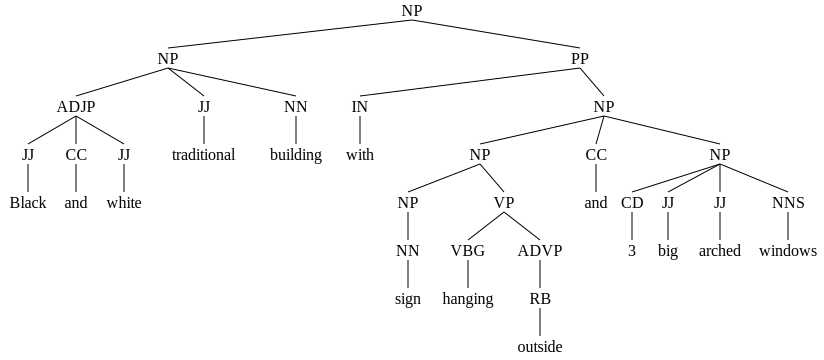

In [ ]:
trees[1]

In [ ]:
len(all_prods)

15429

In [ ]:
# test on the first sentence
test_sent = trees[0].leaves()

for t in parser.parse(test_sent):
# #     # t.pretty_print()
    print(t)

ValueError: Grammar does not cover some of the input words: '"\'", \'Brodie\', "\'s"'.

In [ ]:
# 4. build a grammar (dedupe productions)
start_sym = trees[0].label()           

prods = list({ p for p in all_prods })  # set-dedupe, original producing 2000 cfg rules
grammar = CFG(Nonterminal(start_sym), prods)

punct_tags = {",", ":", "``", "''", ".", "(", ")", "--"}
filtered_prods = [
  p for p in all_prods
  if not any(
    isinstance(sym, Nonterminal) and sym.symbol() in punct_tags
    for sym in p.rhs()
  )
]
# grammar = CFG(Nonterminal(start_sym), filtered_prods) # producing 26k++ rules
print(len(filtered_prods))

25698


In [ ]:
# punct_tags = {",", ":", "``", "''", ".", "(", ")", "--"}
# filtered_prods = [
#   p for p in all_prods
#   if not any(
#     isinstance(sym, Nonterminal) and sym.symbol() in punct_tags
#     for sym in p.rhs()
#   )
# ]
# grammar = CFG(Nonterminal(start_sym), filtered_prods) # producing 25k+ rules
# # before you extract productions, do for each tree:
# for t in trees:
#     # this will break any rule X → A B C D … into a chain of binaries
#     Tree.chomsky_normal_form(t, horzMarkov=2)

# # extract production to keep RHS at length 2 or 1

# from collections import Counter

# counts = Counter(all_prods)
# keep = [p for p in all_prods if counts[p] > 1]   # e.g. freq > 1
# grammar = CFG(Nonterminal(start_sym), list({p for p in keep}))


In [ ]:
print(grammar)

Grammar with 1254 productions (start state = NP)
    VP -> MD PP
    VBN -> 'named'
    NN -> 'blind'
    NNS -> 'pillars'
    NN -> 'archway'
    NN -> 'person'
    NN -> 'postbox'
    ADJP -> CD HYPH VBN
    JJ -> 'beautiful'
    NNS -> 'tables'
    NP -> NP , ADJP
    NN -> 'clock'
    NP -> DT NNP
    NN -> 'day'
    NN -> 'image'
    NP -> DT JJ , JJ NN
    IN -> 'in'
    NN -> 'style'
    VP -> VBZ ADVP VP
    RB -> 'directly'
    JJ -> 'opposite'
    VBN -> 'passed'
    JJ -> 'vertical'
    NN -> 'design'
    IN -> 'up'
    VP -> VBP VP
    VB -> 'look'
    NN -> 'outside'
    NN -> 'tavern'
    S -> NP
    NN -> 'colour'
    NNP -> 'Castro'
    NN -> 'pyramid'
    NP -> DT NML JJ NN
    JJ -> 'outside'
    IN -> 'from'
    S -> CC NP VP
    NNP -> 'Carlton'
    NP -> JJ PP
    NN -> 'part'
    JJ -> 'pretty'
    ADVP -> RBS RB
    NP -> NNS NN
    VBN -> 'nestled'
    RBS -> 'least'
    : -> '-'
    NP -> DT JJ , NML NN
    NNP -> 'Church'
    JJ -> 'twin'
    DT -> 'no'
    DT

In [ ]:
test_tokens = trees[2].leaves()
print(test_tokens)
# for t in parser.parse(test_tokens):
# #     # t.pretty_print()
#     print(t)

['Traditional', 'early', 'Victorian', 'terrace', 'on', '3', 'floors', '+', 'dormer']
